# Tensorflow2: Image Classification using Logistic Regression

### This notebook is a tensorflow port of https://jovian.ml/aakashns/03-logistic-regression

Despite the structural differences in Tensorflow and PyTorch, I have tried to port the torch notebooks to tensorflow, which helps in learning both frameworks along with the course [PyTorch: Zero to GANs](https://jovian.ml/aakashns/01-pytorch-basics) by Aakash

#### Part 3 of "Tensorflow: Zero to GANs"

*This post is the third in a series of tutorials on building deep learning models with tensorflow, an open source neural networks library. Check out the full series:*

1. [Tensorflow Basics: Tensors & Gradients](https://jovian.ml/kartik.godawat/01-tensorflow-basics)
2. [Linear Regression & Gradient Descent](https://jovian.ml/kartik.godawat/02-tf-linear-regression)
3. [Image Classfication using Logistic Regression](https://jovian.ml/kartik.godawat/03-tf-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ml/kartik.godawat/04-tf-feedforward-nn)



In this tutorial, we'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: *image classification*. We'll use the famous [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9), along with labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

### Dataset import and exploration
Tensorflow2.x as of now has two ways of importing mnist dataset using `tf.keras.datasets` and using a library called `tensorflow_datasets`. Let's go through both approaches now.

### Approach-1: keras.datasets

In [2]:
from tensorflow.keras.datasets import mnist

`help()` function can list the available functions in a module

In [3]:
help(tf.keras.datasets)

Help on package tensorflow_core.keras.datasets in tensorflow_core.keras:

NAME
    tensorflow_core.keras.datasets - Public API for tf.keras.datasets namespace.

PACKAGE CONTENTS
    boston_housing (package)
    cifar10 (package)
    cifar100 (package)
    fashion_mnist (package)
    imdb (package)
    mnist (package)
    reuters (package)

FILE
    /home/d/envs/tftwo/lib/python3.6/site-packages/tensorflow_core/python/keras/api/_v2/keras/datasets/__init__.py




In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

The data is already split into a train and a test set, 60k in train and 10k in test

In [5]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [6]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [7]:
type(x_train[0])

numpy.ndarray

The dataset is available to us as numpy array. In order to view the images of 28x28 size, we can use matplotlib to plot the data as an image

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Along with importing `matplotlib`, a special statement `%matplotlib inline` is added to indicate to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called IPython magic commands, and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


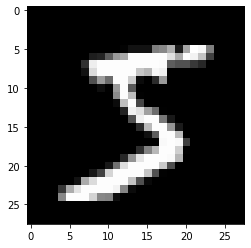

In [9]:
plt.imshow(x_train[0], cmap='gray')
print("Label:", y_train[0])

Label: 5


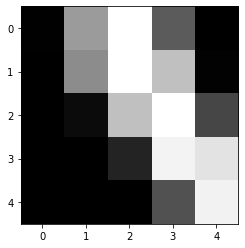

In [10]:
plt.imshow(x_train[0,10:15,10:15], cmap='gray')
print("Label:", y_train[0])

It's evident that these images are quite small in size, and recognizing the digits can sometimes be hard even for the human eye. While it's useful to look at these images, there's just one problem here: Tensorflow doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>

This is similar to the dataset we created in https://jovian.ml/kartik.godawat/02-tf-linear-regression

### Approach-2: tensorflow_datasets

`tensorflow_datasets` is another official library by tensorflow team which helps loading different datasets directly as `tf.data.Dataset`. Keras datasets are very basic toy datasets, whereas this libary is suitable for large datasets as well

In [12]:
!pip install tensorflow_datasets --quiet

You should consider upgrading via the '/home/d/envs/tftwo/bin/python3.6 -m pip install --upgrade pip' command.


In [13]:
import tensorflow_datasets as tfds

A list of available datasets in the current libary can also be viewed from code like this:

In [14]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'cos_e',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'emnist',
 'eraser_multi_rc',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'forest_fires',
 'gap',
 'ge

Similar to keras `mnist.load_data()`, `tfds.load()` api can be used to load mnist data. We're passing `as_supervised=True` for the load method to return a tuple.

In [15]:
(ds, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

The info regarding versioning and other metadata can be viewed in the info object we recieved by passing `with_info=True`

In [16]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

We could have gone ahead with any of the data loads for mnist data. Here, I am choosing to go forward with tensorflow_datasets approach

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

In the MNIST dataset, there are 60,000 training images, and 10,000 test images. The test set is standardized so that different researchers can report the results of their models against the same set of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation.

In [17]:
ds = ds.shuffle(buffer_size=100)

First we shuffle the data, then we use `take()` and `skip()` methods to split the data into train and validation datasets. `buffer_size` in shuffle is to restrict loading the entire data into memory and perform a shuffle. This is necessary for larger datasets.

In [18]:
train_ds = ds.take(50000)
val_ds = ds.skip(50000)

Unfortunately, `tf.data.Dataset` at the time of writing does not support exposing count as a paramater. In order to get the count, there are some hacks, worst of which is below: 

In [19]:
len(list(train_ds)), len(list(val_ds))

(50000, 10000)

Note that for larger datasets, loading entire dataset into memory isn't possible, so while this works for small datasets, it's not a good practice to get the counts like this.

Like [before](https://jovian.ml/kartik.godawat/02-tf-linear-regression/v/3#C51), instead of loading all data, we create a batch to load only 128 images into memory. We do this for both training and validation sets.

In [20]:
batch_size = 128
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

The dataset can be iterated upon and will return data in batches of 128

In [21]:
for x, y in train_ds:
    print(x.shape)
    print(x[0,10:15,10:15])
    break

(128, 28, 28, 1)
tf.Tensor(
[[[0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]]], shape=(5, 5, 1), dtype=uint8)


Note that the values here are between 0-255 representing a grayscale image. We will deal with it later.

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model i.e. there are weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* Just as we did with [linear regression](https://jovian.ml/kartik.godawat/02-tf-linear-regression), we can use `Sequential` to create the model instead of defining and initializing the matrices manually.

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [22]:
num_classes = 10
model = Sequential([
  Dense(num_classes, input_shape=(28*28,))
])

Of course, this model is a lot larger than our previous model, in terms of the number of parameters. Let's take a look at the weights and biases.

In [23]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[-0.02152888,  0.05879454,  0.00226832, ...,  0.0072439 ,
         -0.08685475, -0.01775543],
        [-0.07275616, -0.03554178, -0.06286011, ..., -0.0650673 ,
          0.05680438,  0.01267791],
        [ 0.02990201,  0.04954509, -0.05144789, ...,  0.04712003,
          0.0005519 , -0.06900601],
        ...,
        [-0.02774297,  0.08260164, -0.07678004, ..., -0.01186107,
         -0.08320007, -0.02955337],
        [ 0.04106381, -0.01671977,  0.08499026, ...,  0.03367276,
         -0.05307632,  0.05747337],
        [ 0.055009  ,  0.02731592, -0.05412671, ...,  0.00771543,
         -0.02146795, -0.07764859]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

Although there are a total of 7850 parameters here, conceptually nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset, and pass them into our model.

In [24]:
for images, labels in train_ds:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tf.Tensor(
[3 9 4 2 4 8 6 7 3 6 1 1 1 8 4 7 2 8 3 4 1 7 4 8 5 5 6 4 4 6 3 3 4 7 7 8 9
 4 9 4 9 1 6 4 6 1 0 9 7 6 9 9 9 7 4 6 8 8 4 5 2 3 8 9 2 9 6 1 6 1 7 1 2 4
 9 5 5 5 4 9 7 2 4 1 2 9 6 4 6 1 1 9 4 7 9 6 3 8 3 4 1 4 2 9 1 5 2 8 9 1 2
 8 6 8 3 9 2 2 1 6 7 7 7 8 4 7 5 3], shape=(128,), dtype=int64)
(128, 28, 28, 1)


NotFoundError: Could not find valid device for node.
Node:{{node MatMul}}
All kernels registered for op MatMul :
  device='XLA_GPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='XLA_GPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_BFLOAT16, DT_COMPLEX128, DT_HALF]
  device='CPU'; label='eigen'; T in [DT_COMPLEX128]
  device='CPU'; label='eigen'; T in [DT_COMPLEX64]
  device='CPU'; label='eigen'; T in [DT_INT64]
  device='CPU'; label='eigen'; T in [DT_INT32]
  device='CPU'; label='eigen'; T in [DT_BFLOAT16]
  device='CPU'; label='eigen'; T in [DT_HALF]
  device='CPU'; label='eigen'; T in [DT_DOUBLE]
  device='CPU'; label='eigen'; T in [DT_FLOAT]
  device='CPU'; T in [DT_COMPLEX128]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_INT64]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='GPU'; label='cublas'; T in [DT_HALF]
  device='GPU'; label='cublas'; T in [DT_COMPLEX128]
  device='GPU'; label='cublas'; T in [DT_COMPLEX64]
  device='GPU'; label='cublas'; T in [DT_DOUBLE]
  device='GPU'; label='cublas'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_COMPLEX128]
  device='GPU'; T in [DT_COMPLEX64]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
 [Op:MatMul] name: sequential/dense/Tensordot/MatMul/

This leads to an error, because our input data does not have the right shape. Our images are of the shape 28x28, but we need them to be vectors of size 784 i.e. we need to flatten them out.

We have two approaches here to flatten the data.
- add a Reshape Layer
- modify the dataset and flatten it

#### Approach-1: tensorflow.keras.layers.Reshape

As the name suggests, the objective of the layer `tensorflow.keras.layers.Reshape` is to reshape the input_shape into a given output_shape. 

In [25]:
model = Sequential([
    Reshape((28*28,), input_shape=(28,28,1)),
    Dense(num_classes)
])

Verify that it's working now

In [26]:
for images, labels in train_ds:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tf.Tensor(
[4 5 5 4 7 4 3 1 3 7 8 1 1 1 3 9 0 4 6 2 3 4 6 5 9 2 8 1 8 4 4 3 9 4 7 3 3
 4 1 4 9 7 4 5 7 1 5 7 0 4 2 4 5 7 8 7 2 6 9 8 6 0 6 1 7 6 9 9 7 2 2 6 4 5
 0 3 9 8 8 1 7 9 4 7 8 9 8 2 9 8 1 5 8 4 3 9 1 2 6 1 1 9 4 8 4 3 9 9 8 4 9
 6 0 2 4 9 4 9 9 1 5 6 1 2 9 7 8 8], shape=(128,), dtype=int64)
(128, 28, 28, 1)


#### Approach-2: tf.data.Dataset.apply()

Here we keep the model as same, but instead we modify our train and val datasets

In [27]:
model = Sequential([
  Dense(num_classes, input_shape=(28*28,))
])

Here we are going to `map` each row in the dataset to a function and apply a transformation.
- Since we've already converted the dataset into a batch dataset, we need to `unbatch` it first before using `map`
- Since our dataset was in range of 0-255, it's usually a good idea to get the dataset in a range of 0-1. So we normalize it by dividing it by 255.
- `tf.reshape()` then reshapes the tensor into a flattened shape of [28*28]

In [28]:
def mapp(x):
    x = x / 255
    return tf.reshape(x, [28*28])
train_ds = train_ds.unbatch().map(lambda x,y: (mapp(x),y)).batch(batch_size)
val_ds = val_ds.unbatch().map(lambda x,y: (mapp(x),y)).batch(batch_size)

Verify that it's working now

In [29]:
for images, labels in train_ds:
    outputs = model(images)
    break
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2])

outputs.shape :  (128, 10)
Sample outputs :
 tf.Tensor(
[[ 0.6407453   0.11143446  0.09817434  0.55807185 -0.39174902 -0.11454432
   0.3625155   0.15150255 -0.08574978  0.02495538]
 [-0.47593075 -0.3733762   0.31717196  0.88274086  0.18745703  0.2640057
   0.5768487   0.35867417 -0.61051834 -0.45194724]], shape=(2, 10), dtype=float32)


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities, but for that the elements of each output row must lie between 0 to 1 and add up to 1, which is clearly not the case here. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First we replace each element `yi` in an output row by `e^yi`, which makes all the elements positive, and then we divide each element by the sum of all elements to ensure that they add up to 1. 

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within tensorflow, because it works well with multidimensional tensors (a list of output rows in our case).

In [30]:
# Apply softmax for each output row
probs = tf.nn.softmax(outputs)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2])

# Add up the probabilities of an output row
print("Sum: ", tf.reduce_sum(probs[0]))

Sample probabilities:
 tf.Tensor(
[[0.15845512 0.09333178 0.09210235 0.14588198 0.05642866 0.07445402
  0.11996999 0.09714732 0.07662906 0.08559968]
 [0.05177516 0.05736675 0.1144357  0.20145823 0.10051412 0.10851049
  0.14836714 0.11928497 0.04525544 0.05303192]], shape=(2, 10), dtype=float32)
Sum:  tf.Tensor(0.9999999, shape=(), dtype=float32)


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. This is done using `tf.argmax`, which returns the index of the largest element along a particular dimension of a tensor.

In [31]:
tf.argmax(probs, axis=1)

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 3, 3, 6, 3, 3, 3, 6, 3, 7, 3, 3, 7, 3, 6, 3, 3, 7, 4, 0, 3, 3,
       3, 3, 0, 7, 2, 3, 7, 3, 7, 3, 3, 6, 7, 3, 3, 6, 8, 6, 3, 1, 3, 3,
       6, 7, 6, 6, 3, 5, 8, 3, 3, 7, 6, 3, 3, 1, 6, 8, 1, 3, 6, 6, 0, 3,
       6, 3, 3, 3, 4, 3, 3, 3, 3, 3, 7, 5, 6, 4, 6, 3, 4, 4, 3, 6, 3, 3,
       3, 7, 7, 6, 6, 3, 3, 6, 6, 6, 3, 6, 3, 2, 7, 5, 3, 6, 6, 7, 3, 7,
       3, 5, 0, 6, 6, 3, 6, 6, 7, 6, 3, 7, 7, 8, 3, 3, 3, 2])>

We can use `tf.reduce_max`, which returns the largest element along a particular dimension of a tensor.

In [32]:
tf.reduce_max(probs, axis=1)

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([0.15845512, 0.20145823, 0.1473594 , 0.18312174, 0.14684515,
       0.13821913, 0.20344476, 0.21454631, 0.17464176, 0.17615716,
       0.19924934, 0.191635  , 0.15574196, 0.15451096, 0.16498904,
       0.1951823 , 0.14699866, 0.19517234, 0.13819592, 0.15195793,
       0.16975632, 0.16272886, 0.22997463, 0.22378232, 0.1862738 ,
       0.16766134, 0.16471116, 0.1702503 , 0.16441748, 0.26557878,
       0.1537855 , 0.22680064, 0.15283428, 0.1730881 , 0.21709965,
       0.16072929, 0.25171223, 0.21650884, 0.17280476, 0.15892385,
       0.18534954, 0.25566936, 0.18228438, 0.28055292, 0.22572468,
       0.23617677, 0.1424967 , 0.16862112, 0.1510295 , 0.1263147 ,
       0.1499951 , 0.17324796, 0.20319031, 0.22055261, 0.126317  ,
       0.16002771, 0.1813619 , 0.22873938, 0.14520727, 0.18482171,
       0.20929377, 0.2025224 , 0.14242812, 0.15669467, 0.13586389,
       0.1789451 , 0.16269937, 0.2045537 , 0.1739732 , 0.17395262,
       0.14301

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [33]:
labels

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 8, 7, 1, 6, 7, 4, 3, 9, 4, 5, 4, 2, 1, 3, 8, 9, 4, 1, 9, 4, 7,
       5, 0, 9, 1, 1, 0, 6, 4, 4, 4, 7, 3, 6, 4, 4, 1, 2, 7, 2, 9, 0, 3,
       1, 6, 1, 2, 2, 7, 2, 3, 9, 6, 1, 8, 7, 4, 9, 0, 4, 3, 7, 9, 9, 8,
       5, 3, 2, 4, 7, 8, 0, 4, 0, 6, 6, 7, 3, 9, 1, 1, 9, 4, 8, 1, 0, 4,
       9, 6, 6, 3, 7, 5, 3, 8, 5, 1, 9, 1, 8, 1, 1, 7, 4, 3, 1, 1, 2, 6,
       4, 8, 7, 1, 5, 9, 1, 2, 4, 3, 4, 9, 2, 2, 0, 4, 4, 2])>

## Evaluation metric and loss function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

- We use `tf.reduce_sum` to get the sum all elements of a tensor
- Since `preds==labels` will return a tensor with boolean values, we need to cast it to integers 0-1 to have the sum. It is done using `tf.cast`

In [34]:
def accuracy(outputs, labels):
    preds = tf.argmax(outputs, axis=1)
    return tf.reduce_sum(tf.cast(preds == labels, dtype=tf.int32)) / len(preds)

Note that we don't need to apply softmax to the outputs, since it doesn't change the relative order of the results. This is because e^x is an increasing function i.e. if y1 > y2, then e^y1 > e^y2 and the same holds true after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model, on the first batch of data. Obviously, we expect it to be pretty bad.

In [35]:
accuracy(outputs, labels)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0625>

While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

1. It's not a differentiable function. `tf.argmax` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

Due to these reasons, accuracy is a great **evaluation metric** for classification, but not a good loss function. A commonly used loss function for classification problems is the **cross entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function. 

As you might expect, Tensorflow provides an efficient and tensor-friendly implementation of cross entropy as `tf.keras.losses.CategoricalCrossentropy()`.

In [36]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

labels hold a single value per image denoting which class the image belongs to. However, the loss categorical_crossentropy, expects the labels to be [one hot encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f). Keras provides a helper `utils.to_categorical()` to convert the labels into one hot encoded vectors. 

One hot encoded vector has length equal to number of classes and has value 1 on actual class and 0 elsewhere. For exmaple, an image with label=7 will have 1 present at 7th index and rest all values will be 0.

In [37]:
label_categorical = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
label_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [38]:
# Loss for current batch of data
loss = loss_fn(tf.nn.softmax(outputs), label_categorical)
print(loss)

tf.Tensor(14.637895, shape=(), dtype=float32)


The lower the loss, the better

## Training the model

Now that we have defined the dataset, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We define some helper functions to perform validation steps

In [39]:
def validation_step(model, x, y):
    out = model(x)
    out = tf.nn.softmax(out)
    loss = loss_fn(out, tf.keras.utils.to_categorical(y, num_classes=num_classes))
    acc = accuracy(out, y)
    return {'loss': loss, 'acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['loss'] for x in outputs]
    epoch_loss = tf.reduce_mean(batch_losses)   # Combine losses
    batch_accs = [x['acc'] for x in outputs]
    epoch_acc =  tf.reduce_mean(batch_accs)      # Combine accuracies
    return {'loss': epoch_loss, 'acc': epoch_acc}

Now we'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will peform the entire training process.

In [40]:
def evaluate(model, val_ds):
    outputs = []
    for x, y in val_ds:
        outputs.append(validation_step(model, x, y))
    return validation_epoch_end(outputs)

def fit(epochs, lr, model, train_ds, val_ds, opt_func=tf.keras.optimizers.SGD):
    history = []
    optimizer = opt_func(lr)
    for epoch in range(epochs):
        # Training Phase 
        for x, y in train_ds:
            # Record all operations under GradientTape, so that gradients can be tracked and calculated later
            with tf.GradientTape() as tape:
                out = model(x)
                out = tf.nn.softmax(out)
                loss = loss_fn(out, tf.keras.utils.to_categorical(y, num_classes=10))
            var_list_fn =  model.trainable_weights
            # Compute gradients
            grads = tape.gradient(loss, var_list_fn)
#             print(grads)
            # Apply gradients
            optimizer.apply_gradients(zip(grads, var_list_fn))
        # Validation phase
        result = evaluate(model, train_ds)
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['loss'], result['acc']))
        result = evaluate(model, val_ds)
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['loss'], result['acc']))
        history.append(result)
    return history

The `fit` function records the validation loss and metric from each epoch and returns a history of the training process. This is useful for debuggin & visualizing the training process. Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.

Configurations like batch size, learning rate etc. need to picked in advance while training machine learning models, and are called hyperparameters. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. Feel free to try different learning rates and see how it affects the training process.

In [41]:
result0 = evaluate(model, val_ds)
result0

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=14.595188>,
 'acc': <tf.Tensor: shape=(), dtype=float64, numpy=0.07199367088607594>}

We are now ready to train the model. Let's train for 5 epochs and look at the results.

In [42]:
history1 = fit(5, 0.001, model, train_ds, val_ds)

Epoch [0], train_loss: 12.1983, train_acc: 0.3573
Epoch [0], val_loss: 12.2435, val_acc: 0.3528
Epoch [1], train_loss: 9.8435, train_acc: 0.5760
Epoch [1], val_loss: 9.8783, val_acc: 0.5789
Epoch [2], train_loss: 7.9379, train_acc: 0.6345
Epoch [2], val_loss: 7.9507, val_acc: 0.6372
Epoch [3], train_loss: 7.2194, train_acc: 0.6435
Epoch [3], val_loss: 7.2092, val_acc: 0.6489
Epoch [4], train_loss: 6.7563, train_acc: 0.6627
Epoch [4], val_loss: 6.7075, val_acc: 0.6694


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 66% on the validation set. Let's see if we can improve that by training for a few more epochs.

In [43]:
history2 = fit(15, 0.001, model, train_ds, val_ds)

Epoch [0], train_loss: 6.1452, train_acc: 0.7127
Epoch [0], val_loss: 6.1445, val_acc: 0.7141
Epoch [1], train_loss: 5.8445, train_acc: 0.7199
Epoch [1], val_loss: 5.8713, val_acc: 0.7203
Epoch [2], train_loss: 5.6321, train_acc: 0.7248
Epoch [2], val_loss: 5.6090, val_acc: 0.7281
Epoch [3], train_loss: 5.4704, train_acc: 0.7283
Epoch [3], val_loss: 5.4409, val_acc: 0.7320
Epoch [4], train_loss: 5.3484, train_acc: 0.7306
Epoch [4], val_loss: 5.3578, val_acc: 0.7321
Epoch [5], train_loss: 5.2425, train_acc: 0.7329
Epoch [5], val_loss: 5.2265, val_acc: 0.7366
Epoch [6], train_loss: 5.1591, train_acc: 0.7344
Epoch [6], val_loss: 5.1148, val_acc: 0.7388
Epoch [7], train_loss: 5.0860, train_acc: 0.7359
Epoch [7], val_loss: 5.0646, val_acc: 0.7386
Epoch [8], train_loss: 5.0225, train_acc: 0.7370
Epoch [8], val_loss: 4.9764, val_acc: 0.7409
Epoch [9], train_loss: 4.9588, train_acc: 0.7382
Epoch [9], val_loss: 4.8989, val_acc: 0.7434
Epoch [10], train_loss: 4.8876, train_acc: 0.7389
Epoch [10]

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. This is easier to see using a line graph.

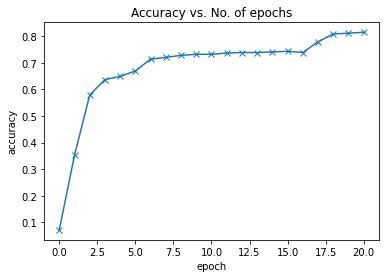

In [44]:
# Replace these values with your results
history = [result0] + history1 + history2
accuracies = [result['acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that the learning rate might be too high. It's possible that the model's paramaters are "bouncing" around the optimal set of parameters that have the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that **the model just isn't powerful enough**. If you remember our initial hypothesis, we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias. This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents. While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc. 

This would be a good time to save our work. Along with the notebook, we can also record some metrics from our training.

In [1]:
import jovian

In [48]:
history[-1]['acc'].numpy()

0.8149723101265823

In [49]:
history[-1]['loss'].numpy()

4.081425

In [50]:
jovian.log_metrics(val_acc=history[-1]['acc'].numpy(), val_loss=history[-1]['loss'].numpy())

TypeError: Object of type 'float32' is not JSON serializable

## Saving and loading the model
Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

First let's evaluate the current mode's accuracy and loss on validation set for reference

In [74]:
result0 = evaluate(model, val_ds)
result0

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0535293>,
 'acc': <tf.Tensor: shape=(), dtype=float64, numpy=0.8762856012658228>}

The weights for the parameters in model can be saved by using `model.save_weights()` function similar to state_dict() in torch. Note that in order to load the model again, the model definition has to be same (like we defined using Sequential api).

In [75]:
model.save_weights("model.h5")

Now let's train for a couple more epochs to make the model shift weights

In [76]:
history3 = fit(2, 0.01, model, train_ds, val_ds)

Epoch [0], train_loss: 2.6336, train_acc: 0.8879
Epoch [0], val_loss: 2.6016, val_acc: 0.8882
Epoch [1], train_loss: 2.4319, train_acc: 0.8935
Epoch [1], val_loss: 2.4085, val_acc: 0.8926


Evaluate the current model's performance on validation data

In [77]:
result0 = evaluate(model, val_ds)
result0

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4060795>,
 'acc': <tf.Tensor: shape=(), dtype=float64, numpy=0.8927017405063291>}

If for whatevever reason, we need to reload the older weights again, it can be done using `model.load_weights()` api.

In [78]:
model.load_weights("model.h5")

Again evaluate the performance

In [88]:
result0 = evaluate(model, val_ds)
result0

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0632868>,
 'acc': <tf.Tensor: shape=(), dtype=float64, numpy=0.8753955696202531>}

# Testing against random images

In [101]:
ds_test = ds_test.map(lambda x,y: (mapp(x),y))

Label: 1
Predicted 1


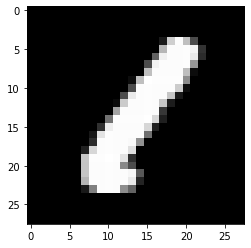

In [121]:

for x, y in val_ds:
    plt.imshow(x[0].numpy().reshape(28,28), cmap='gray')
    print("Label:", y[0].numpy())
    pred = model(x)
#     print(pred[0])
    print("Predicted", tf.argmax(pred[0]).numpy())
    break

## Commit and upload the notebook

As a final step, we can save and commit our work using the jovian library. Along with the notebook, we can also attach the weights of our trained model, so that we can use it later.

In [ ]:
jovian.commit(filename='03-tf-logistic-regression', outputs=['model.h5'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
